In [20]:
# Import necessary libraries
import h5py
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sys
import os
# Add the repo root directory to sys.path
sys.path.append(os.path.abspath('..'))
os.chdir('..')
from root import ROOT_DIR
NORM = 47.83 #use 14.98 for 10 year

Datasets in the file: ['test', 'train']
Shape of dataset: (1557, 18, 64, 64)


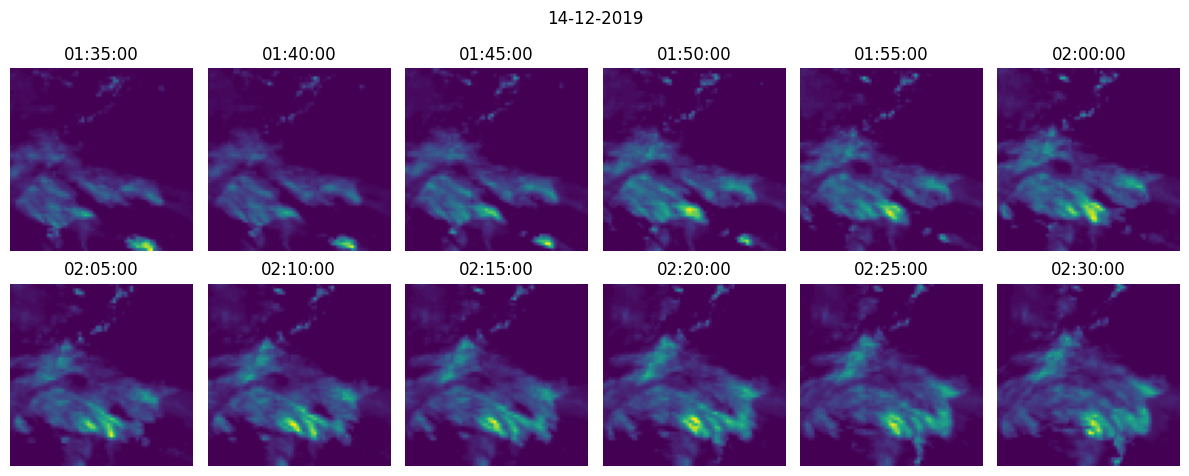

In [46]:
# Open the HDF5 file
with h5py.File(file_path, 'r') as hdf:
    # Print the available datasets to understand the structure
    print("Datasets in the file:", list(hdf.keys()))
    
    # Specify the dataset containing the images
    data = hdf['test']['images']
    timestamps = hdf['test']['timestamps']
    
    # Check the shape of the dataset
    print("Shape of dataset:", data.shape)
    
    # Set the number of images to display
    num_images = 12
    if data.shape[0] < num_images:
        num_images = data.shape[0]
        print(f"Only {num_images} images available in the dataset.")

    # Plot images in a grid
    index= 1500
    plt.figure(figsize=(12, 5))
    images=data[index]
    timestamp=timestamps[index]
    ts = None
    for i in range(num_images):
        # Select and normalize the image
        img = images[i]
        ts = timestamp[i]
        ts = ts[0].decode("utf-8")
        ts = datetime.strptime(ts, "%d-%b-%Y;%H:%M:%S.%f")
        #img_normalized = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
        
        # Plot the image
        plt.subplot(2, 6, i + 1)
        plt.imshow(img, cmap='viridis')
        plt.axis('off')
        plt.title(f"{ts.time()}")

    plt.suptitle(ts.date())
    plt.tight_layout()
    plt.show()

In [59]:
# Open the HDF5 file
from models import unet_precip_regression_lightning as unet_regr
import torch
from torch import nn, triangular_solve
import tqdm

index = 1500 #5042 #2020 #204

persistence = None
output_data = None

kriging_dataset = ROOT_DIR / "data" / "precipitation" / "Krige_2016-2019.h5"
fusion_dataset = ROOT_DIR / "data" / "precipitation" / "Node_2016-2019.h5"

krige_data = None
node_data = None
smaat_data = None

with h5py.File(kriging_dataset, 'r') as hdf:
    data = hdf['test']['images']
    data_k = hdf['test']['kriging']
    input_krige = data_k[index][:12,:,:].copy()
    input_image = data[index][:12,:,:].copy()
    output = data[index][-1,:,:].copy()
    
    krige_data = (input_image, input_krige), output

with h5py.File(fusion_dataset, 'r') as hdf:
    data = hdf['test']['images']
    data_n = np.array(hdf['test']['nodes'][index], dtype="float32")
    data_n = data_n.transpose(1, 0, 2)
    input_nodes = data_n[:12,:,:].copy()
    input_image = data[index][:12,:,:].copy()
    output = data[index][-1,:,:].copy()
    
    node_data = (input_image, input_nodes), output
    smaat_data = input_image, output
    persistence = input_image[-1]
    output_data = output
    

model_folder = ROOT_DIR / "comparison"

model1, model_name1 = unet_regr.SmaAt_UNet, "SmaAt-UNet"
model1 = model1.load_from_checkpoint(f"{model_folder}/Smaat/SmaAt_UNet_small_rain_threshold_50_epoch=28-val_loss=0.013161.ckpt")

model3, model_name3 = unet_regr.Krige_GNet, "SmaAt-Krige-GNet"
model3 = model3.load_from_checkpoint(f"{model_folder}/Krige/Krige_GNet_small_rain_threshold_50_epoch=157-val_loss=0.006280.ckpt")

model2, model_name2 = unet_regr.Node_SmaAt_bridge, "SmaAt-fUsion"
model2 = model2.load_from_checkpoint(f"{model_folder}/Bridge/Node_SmaAt_bridge_small_rain_threshold_50_epoch=41-val_loss=0.011158.ckpt")

model_selection = [model1, model2, model3]
model_input = [smaat_data, node_data, krige_data]
model_names = [model_name1, model_name2, model_name3]

results = []

for i in tqdm.tqdm(range(len(model_selection))):
    cuda = torch.device("cuda")
    model = model_selection[i]

    if model_names[i] == "SmaAt-UNet":
        x, y_true = model_input[i]
        x = torch.from_numpy(x).to(cuda)
        y_true = torch.from_numpy(y_true).to(cuda)
        model.eval()  # or model.freeze()?
        model.to(cuda)
        y_pred = model(x.unsqueeze(0)).squeeze()
        results.append(y_pred)
    else:
        (x, x2), y_true = model_input[i]
        x = torch.from_numpy(x).to(cuda)
        x2 = torch.from_numpy(x2).to(cuda)
        y_true = torch.from_numpy(y_true).to(cuda)
        model.eval()  # or model.freeze()?
        model.to(cuda)
        y_pred = model(x.unsqueeze(0), x2.unsqueeze(0)).squeeze()
        results.append(y_pred)


100%|██████████| 3/3 [00:00<00:00, 98.27it/s]

torch.Size([1, 96, 64, 64])


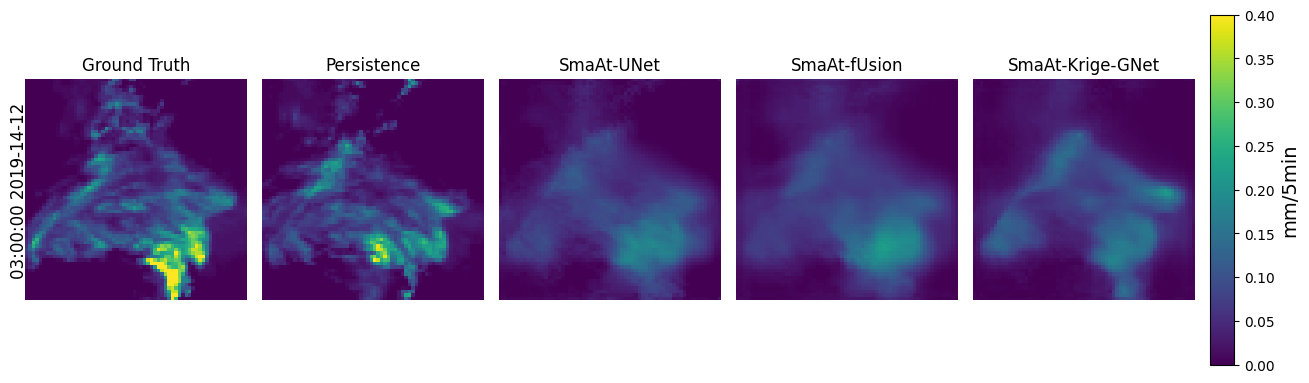

In [66]:
# Set up the figure
plt.figure(figsize=(12, 5))  # Adjust figsize as needed

#unnormalize persistence and output
p_adj = persistence * NORM # * 12
output_adj = output_data * NORM #* 12

all_images = [p_adj, output_adj] + [results[k].cpu().detach().numpy() * NORM * 12.0 for k in range(len(results))]

global_min = min([img.min() for img in all_images])
global_max = max([img.max() for img in all_images])

global_min = 0
global_max = 0.4

# Plot persistence
plt.subplot(1, 5, 2)

im = plt.imshow(p_adj, cmap='viridis',vmin=global_min, vmax=global_max)
plt.axis('off')
plt.title("Persistence")

# Plot the other images
for i in range(len(results)):
    plt.subplot(1, 5, i + 3)  # Start placing images from the 2nd position
    img = results[i].cpu().detach().numpy()
    #denormalize
    img = img * NORM
    img = img #* 12 # to mm/hr
    plt.imshow(img, cmap='viridis',vmin=global_min, vmax=global_max)
    plt.axis('off')
    plt.title(model_names[i])

plt.subplot(1, 5, 1)
plt.imshow(output_adj, cmap='viridis',vmin=global_min, vmax=global_max)
plt.axis('off')
plt.title("Ground Truth")
# Adjust layout
plt.tight_layout()
cbar_ax = plt.gcf().add_axes([1, 0.15, 0.02, 0.7])  # Adjust position of color bar
cbar = plt.colorbar(im, cax=cbar_ax, label="mm/5min")
cbar.set_label("mm/5min", fontsize=14)
plt.gcf().text(0, 0.5, "03:00:00 2019-14-12", fontsize=12, rotation='vertical', va='center')
plt.show()

0.0
2.3121524
-0.0
2.7114234
0.0
2.5610673


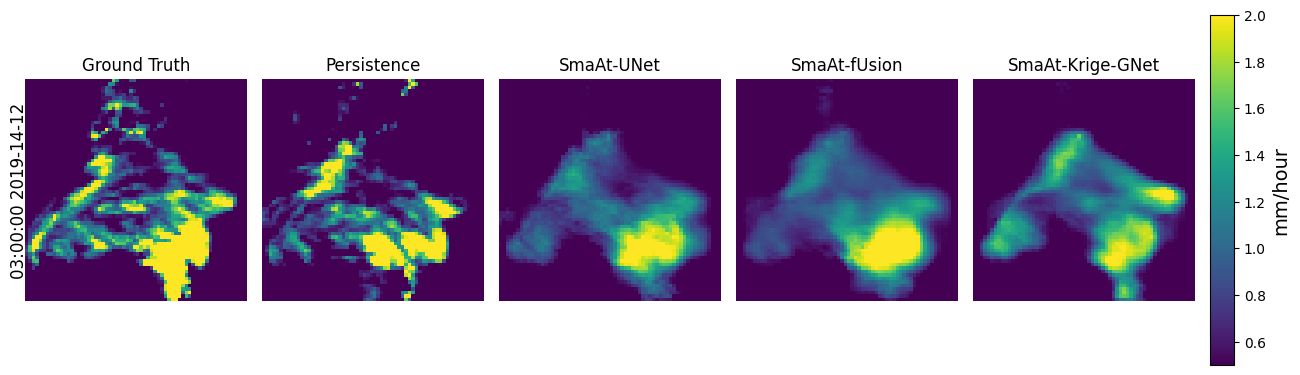

0.0
6.8088894


In [65]:
#PRINT WITH THRESHOLD
plt.figure(figsize=(12, 5))  # Adjust figsize as needed

threshold = 0.5

#unnormalize persistence and output
p_adj = persistence * NORM * 12
output_adj = output_data * NORM * 12
#mask persistence and output
p_mask = p_adj > threshold
output_mask = output_adj > threshold

p = p_adj*p_mask
o = output_adj*output_mask
#plot persistence
plt.subplot(1, 5, 2)
all_images = [p, o] + [results[k].cpu().detach().numpy() * NORM * 12.0 for k in range(len(results))]
global_min = min([img.min() for img in all_images])
global_max = max([img.max() for img in all_images])

global_min = 0.5
global_max = 2


im = plt.imshow(p, cmap='viridis', vmin=global_min, vmax=global_max)
plt.axis('off')
plt.title("Persistence")

# Plot the other images
for i in range(len(results)):
    plt.subplot(1, 5, i + 3)  # Start placing images from the 2nd position
    img = results[i].cpu().detach().numpy()
    #denormalize
    img2 = img * NORM
    #convert to mm/hour
    img_adj = img2 * 12.0
    y_true_adj = output_data * 12.0

    y_pred_mask = img_adj > threshold
    y_true_mask = y_true_adj > threshold
    y_pred_mask.reshape((64,64))
    result = img_adj*y_pred_mask
    print(result.min())
    print(result.max())

    plt.imshow(result, cmap='viridis', vmin=global_min, vmax=global_max)
    plt.axis('off')
    plt.title(model_names[i])

#add output to plot
plt.subplot(1, 5, 1)
plt.imshow(o, cmap='viridis', vmin=global_min, vmax=global_max)
plt.axis('off')
plt.title("Ground Truth")
# Adjust layout
plt.tight_layout()
cbar_ax = plt.gcf().add_axes([1, 0.15, 0.02, 0.7])  # Adjust position of color bar

cbar = plt.colorbar(im, cax=cbar_ax, label="mm/hour")
cbar.set_label("mm/hour", fontsize=14)
plt.gcf().text(0, 0.5, "03:00:00 2019-14-12", fontsize=12, rotation='vertical', va='center')

plt.show()
print(o.min())
print(o.max())